## Import libraries

In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dirty_completeness

## Useful Functions

In [90]:
def hists_plot(df):
    fig, axes = plt.subplots(1, len(df.columns), figsize=(20,5))
    ax = axes.flatten()
    for i, col in enumerate(df.columns):
        sns.countplot(df, x=col, ax=axes[i], order=sorted(df[col].value_counts().index))

In [91]:
def accuracy(df, df_imputed):
    accuracy = {}
    for col in df.columns:
        equal = np.where(df[col] == df_imputed[col], True, False)
        accuracy[col] = equal[equal == True].sum() / len(equal)
    return accuracy

## Read data

In [92]:
users = pd.read_csv('users.csv')

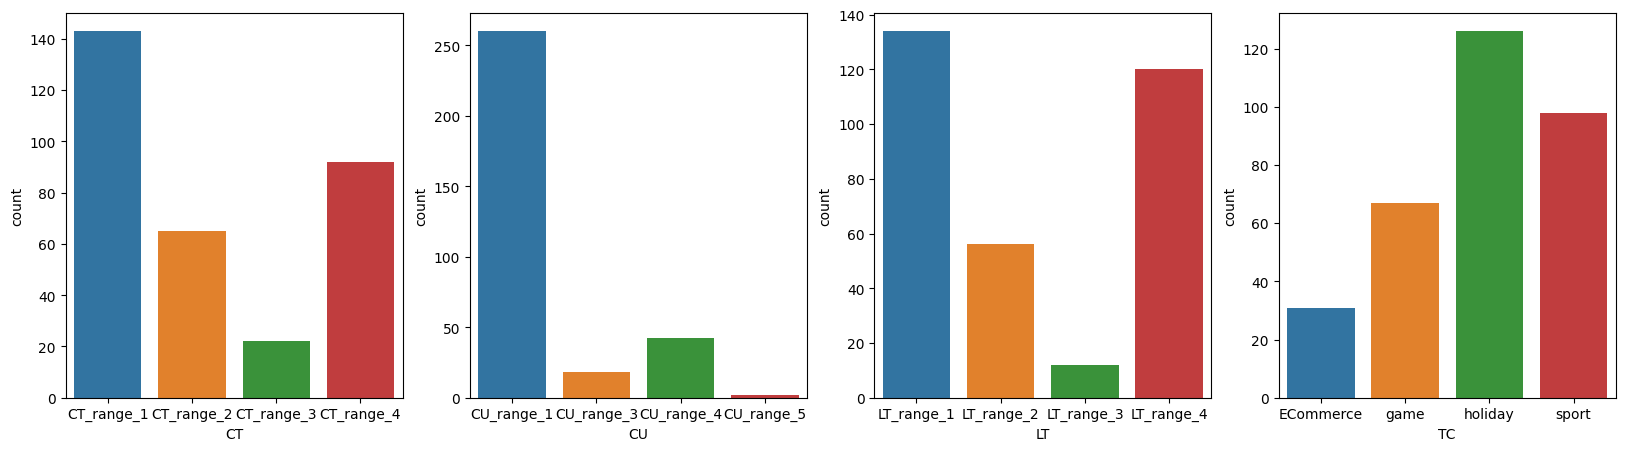

In [93]:
hists_plot(users)

## Shuffle data

In [94]:
users = users.sample(frac=1, axis=0).reset_index(drop=True)

## Inject null values

In [95]:
users_dirty = np.array(dirty_completeness.injection(df_pandas=users, seed=1234, name = 'users', name_class="none"))

saved users-completeness50%
saved users-completeness60%
saved users-completeness70%
saved users-completeness80%
saved users-completeness90%


In [96]:
users_dirty = users_dirty[0,:,:] #50% completeness

In [97]:
users_dirty = pd.DataFrame(users_dirty,columns=users.columns)

In [98]:
users_dirty

,CT,CU,LT,TC
0,NaN,CU_range_1,NaN,NaN
1,CT_range_1,CU_range_1,LT_range_1,holiday
2,NaN,CU_range_1,NaN,game
3,CT_range_1,NaN,NaN,ECommerce
4,CT_range_4,CU_range_1,LT_range_2,NaN
...,...,...,...,...
317,CT_range_1,NaN,LT_range_1,holiday
318,CT_range_1,NaN,NaN,NaN
319,CT_range_2,NaN,LT_range_4,sport
320,CT_range_4,CU_range_1,LT_range_1,NaN


## Visualizing null values

<AxesSubplot:>

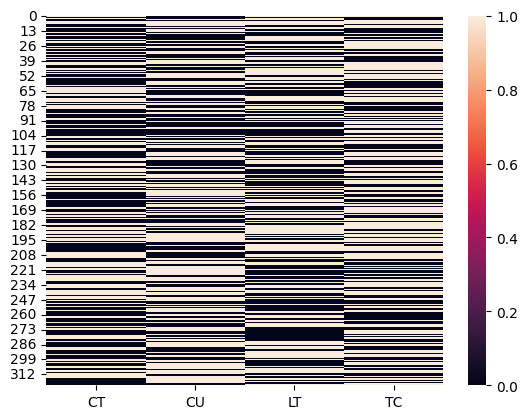

In [99]:
sns.heatmap(users_dirty.isna())

## Simple Imputation

In [100]:
users_simple_imp = users_dirty.fillna(method='ffill')
users_simple_imp.isna().count()
users_simple_imp = users_simple_imp.fillna(method='bfill')

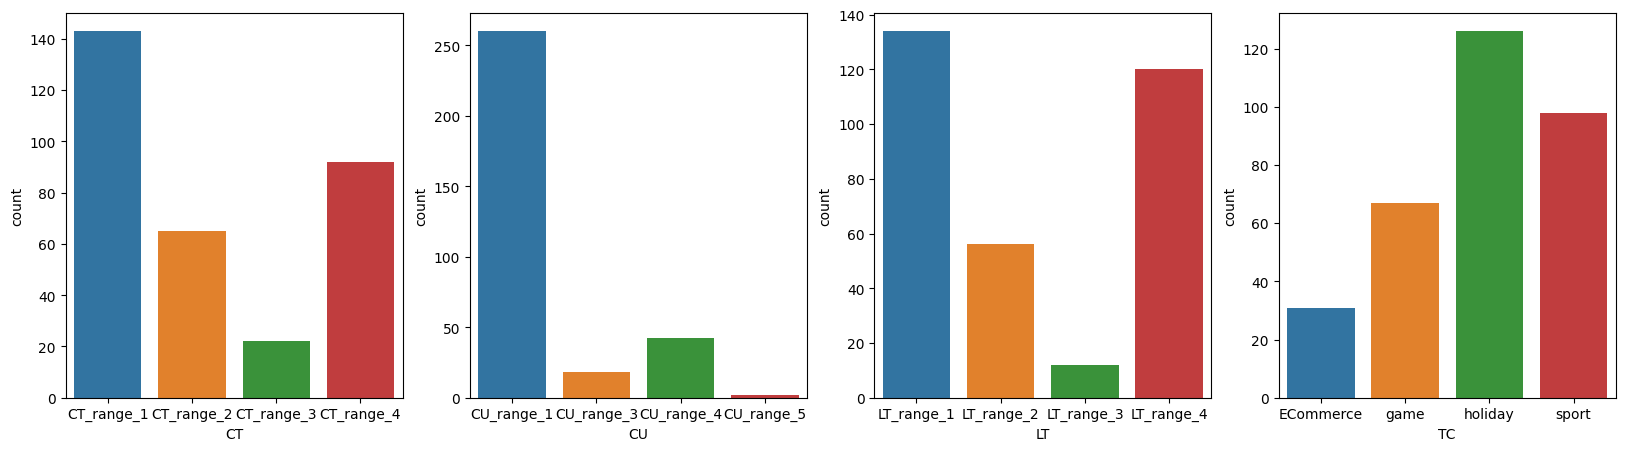

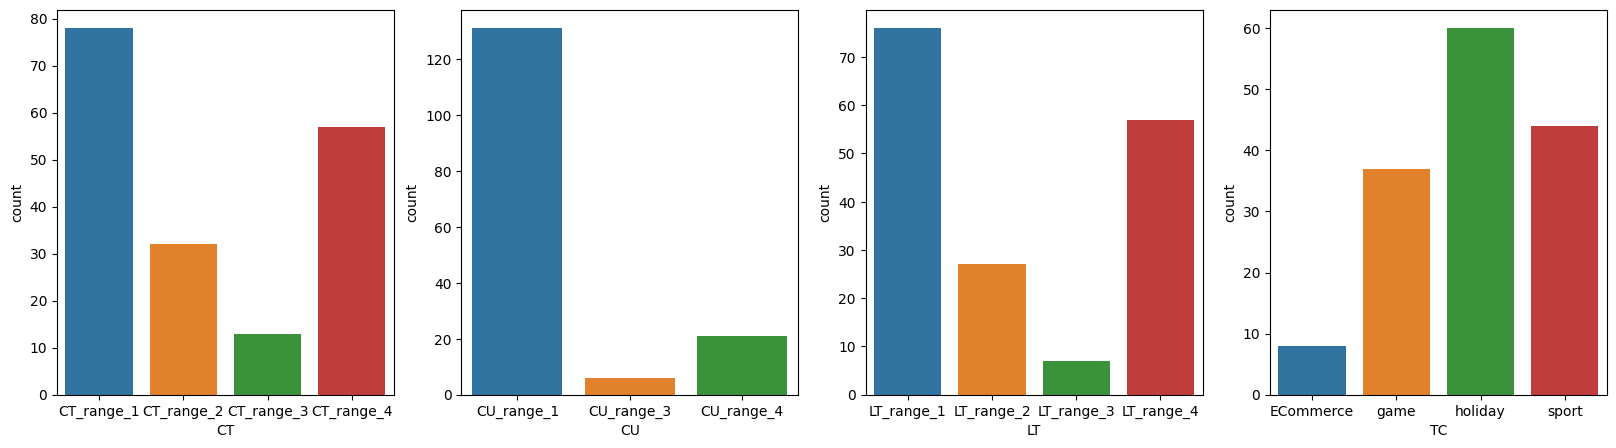

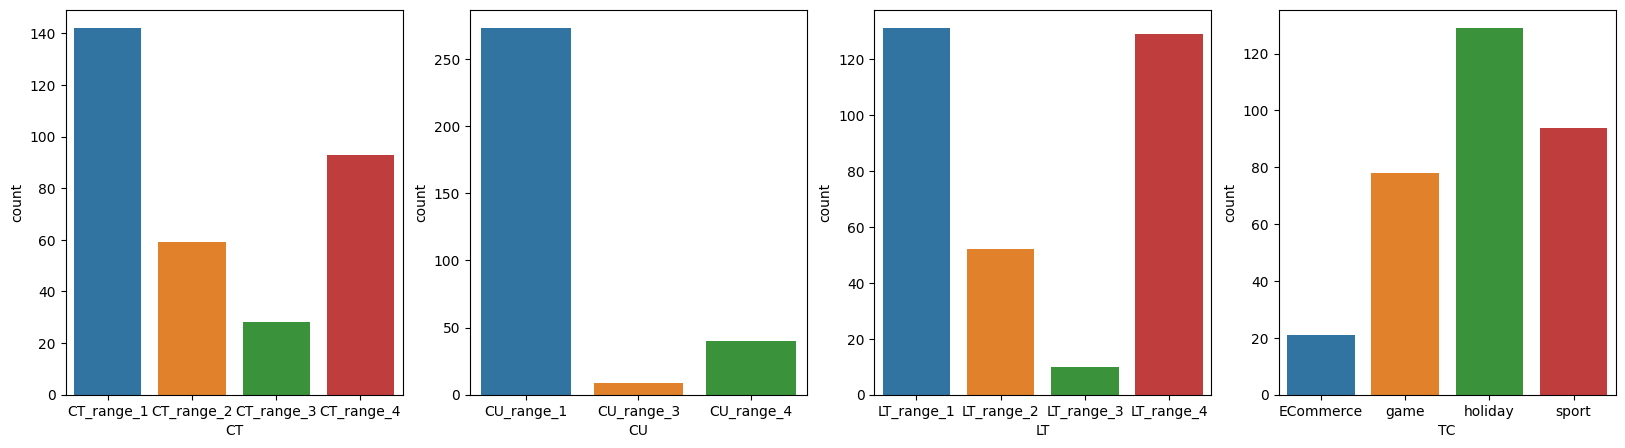

In [101]:
hists_plot(users)
hists_plot(users_dirty)
hists_plot(users_simple_imp)

In [102]:
accuracy(users, users_simple_imp)

{'CT': 0.6894409937888198,
 'CU': 0.8385093167701864,
 'LT': 0.6863354037267081,
 'TC': 0.5993788819875776}

## Advanced Imputation

In [103]:
users_dirty_one_hot = pd.get_dummies(users_dirty)
for col in users_dirty.columns:
    users_dirty_one_hot.loc[users_dirty[col].isnull(), users_dirty_one_hot.columns.str.startswith(col)] = np.nan

In [104]:
from sklearn.impute import KNNImputer

In [105]:
knn_imputer = KNNImputer(n_neighbors=4)
users_knn_imp_one_hot = pd.DataFrame(knn_imputer.fit_transform(users_dirty_one_hot))
users_knn_imp_one_hot.columns = users_dirty_one_hot.columns

In [106]:
users_knn_imp = pd.DataFrame()
for col in users_dirty.columns:
   users_knn_imp[col] = users_knn_imp_one_hot.loc[:, users_knn_imp_one_hot.columns.str.startswith(col)].idxmax(1)
users_knn_imp = users_knn_imp.apply(lambda e: e.str[3:] )

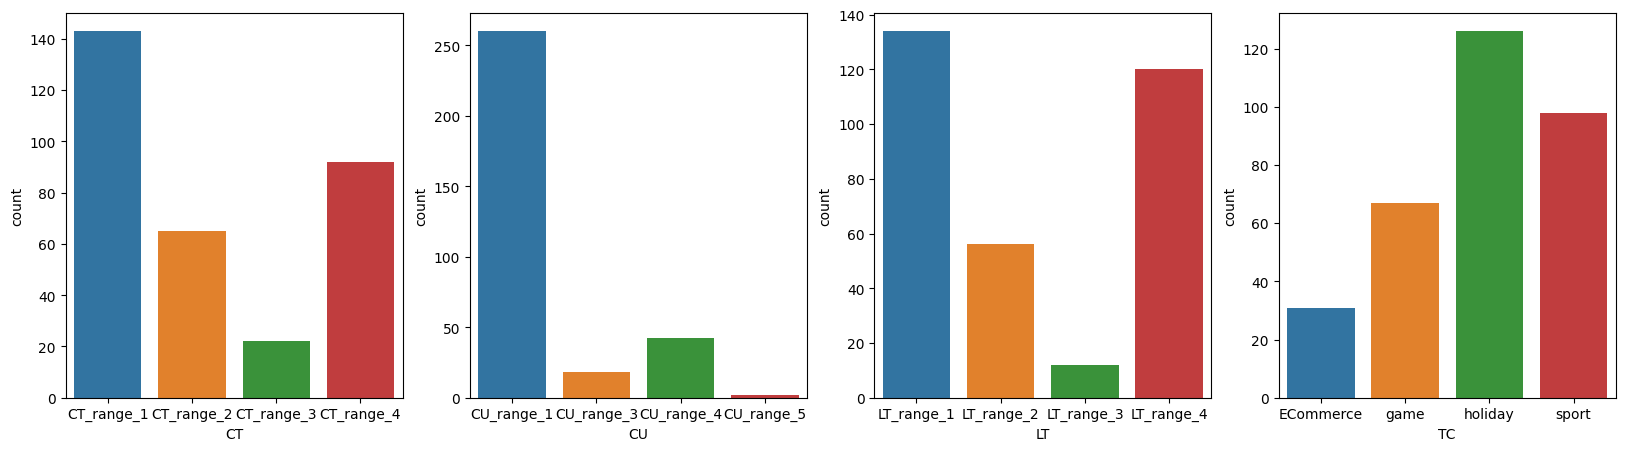

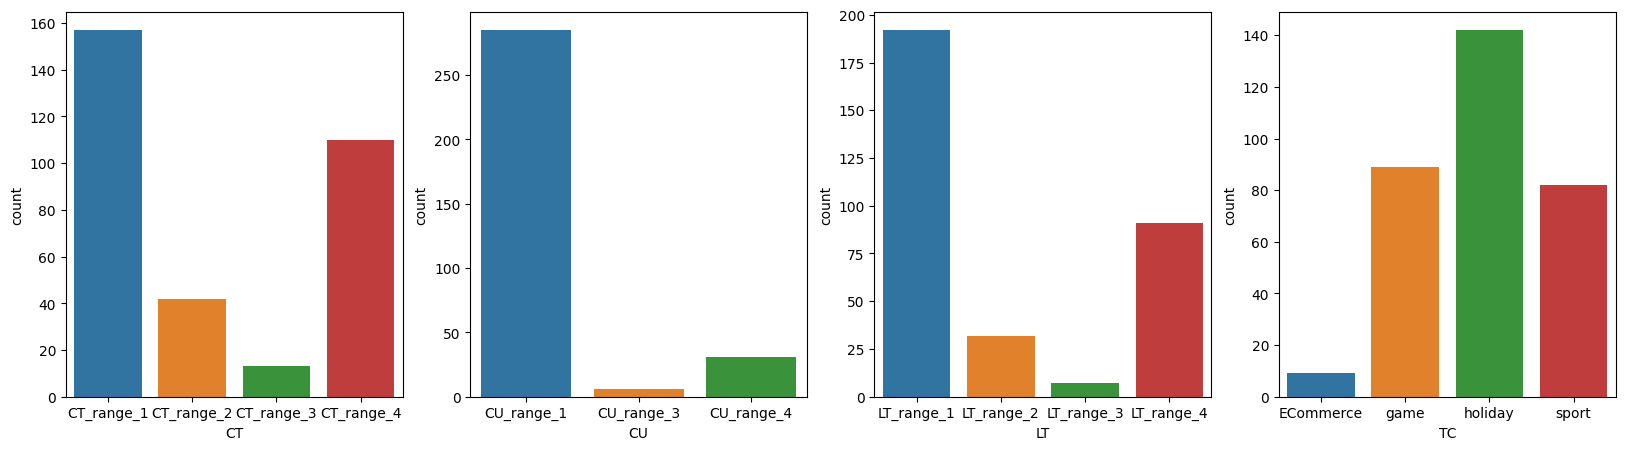

In [107]:
hists_plot(users)
hists_plot(users_knn_imp)

In [108]:
accuracy(users,users_knn_imp)

{'CT': 0.8167701863354038,
 'CU': 0.906832298136646,
 'LT': 0.7546583850931677,
 'TC': 0.7701863354037267}

## Clustering

Because of the categorical nature of the dataset, KModes is performed

In [109]:
%pip install kmodes

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [110]:
from kmodes.kmodes import KModes

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 512.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 512.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 512.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 512.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 512.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 446.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 95, cost: 333.0
Run 2, iteration: 2/100, moves: 2, cost: 333.0
Init: initializing centroids
Init: initia

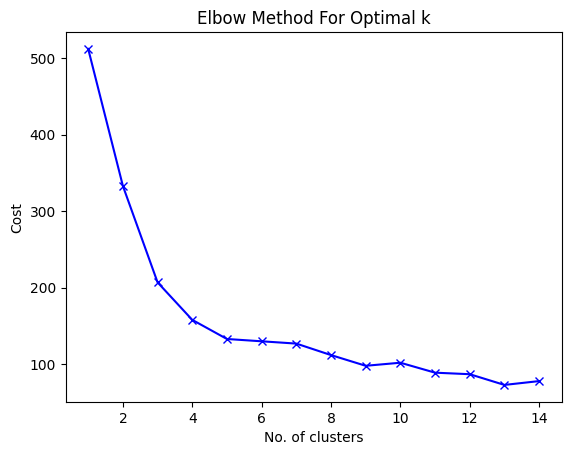

In [111]:
# Elbow curve to find optimal K
cost = []
K = range(1,15)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(users_knn_imp)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()


According to the elbow plot we get the optimal number of cluster k=5

In [112]:
kmodes = KModes(n_jobs = -1, n_clusters = 5, init = 'random', random_state = 0)
kmodes.fit_predict(users_knn_imp)

array([4, 2, 4, 3, 4, 2, 2, 2, 3, 1, 2, 2, 4, 0, 2, 2, 3, 0, 1, 0, 4, 2,
       4, 1, 0, 2, 4, 4, 4, 4, 4, 2, 3, 1, 2, 3, 2, 3, 4, 0, 2, 2, 3, 2,
       3, 1, 4, 3, 4, 0, 3, 1, 2, 2, 4, 0, 2, 3, 1, 2, 4, 1, 2, 0, 2, 2,
       1, 4, 2, 4, 3, 1, 4, 4, 4, 2, 0, 3, 3, 2, 2, 4, 4, 1, 2, 3, 1, 0,
       4, 3, 4, 3, 3, 2, 2, 1, 2, 2, 2, 0, 0, 0, 3, 2, 0, 4, 2, 2, 2, 2,
       4, 2, 2, 3, 3, 2, 0, 4, 2, 2, 2, 4, 4, 2, 2, 3, 2, 3, 2, 2, 2, 3,
       4, 4, 4, 3, 2, 2, 2, 2, 3, 2, 3, 4, 4, 1, 2, 0, 2, 1, 1, 0, 4, 2,
       2, 3, 3, 4, 4, 0, 2, 1, 3, 4, 4, 3, 4, 0, 4, 1, 3, 4, 3, 0, 4, 0,
       1, 2, 2, 2, 0, 3, 3, 0, 2, 0, 4, 2, 4, 2, 1, 2, 1, 1, 3, 2, 2, 2,
       4, 0, 4, 2, 0, 4, 4, 3, 0, 1, 4, 4, 1, 4, 4, 3, 4, 4, 2, 2, 2, 4,
       2, 2, 4, 4, 3, 3, 2, 1, 0, 2, 1, 4, 1, 2, 3, 4, 2, 2, 0, 2, 4, 2,
       4, 4, 2, 0, 2, 3, 2, 3, 2, 2, 4, 3, 2, 4, 3, 4, 0, 3, 1, 2, 2, 2,
       4, 4, 1, 2, 1, 2, 4, 1, 2, 2, 2, 1, 1, 2, 1, 1, 4, 3, 1, 2, 2, 1,
       4, 4, 1, 2, 0, 0, 4, 4, 0, 4, 2, 1, 4, 2, 1,

In [113]:
users_knn_imp['Cluster'] = kmodes.labels_

In [114]:
users_knn_imp

,CT,CU,LT,TC,Cluster
0,CT_range_4,CU_range_1,LT_range_1,game,4
1,CT_range_1,CU_range_1,LT_range_1,holiday,2
2,CT_range_4,CU_range_1,LT_range_4,game,4
3,CT_range_1,CU_range_1,LT_range_4,ECommerce,3
4,CT_range_4,CU_range_1,LT_range_2,game,4
...,...,...,...,...,...
317,CT_range_1,CU_range_1,LT_range_1,holiday,2
318,CT_range_1,CU_range_1,LT_range_4,holiday,2
319,CT_range_2,CU_range_1,LT_range_4,sport,3
320,CT_range_4,CU_range_1,LT_range_1,game,4
